In [1]:
from importlib import reload
import numpy
import pandas as pd
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from gradient import MyGDRegressor
from knn import CustomKNeighborsRegressor
from evaluation import evaluator

reload(evaluator)

<module 'evaluation.evaluator' from 'C:\\TU_Wien\\2_Master\\ML\\exercise-2\\evaluation\\evaluator.py'>

# Infrared Thermography Temperature

In [2]:
infrared_df = pd.read_csv("./infrared/FLIR_groups1and2.csv", header=None)
# Get actual header
infrared_headers = infrared_df.iloc[2]
# Remove Round header and measurements generic term
infrared_df = infrared_df[3:]
infrared_df.columns = infrared_headers

# Drop NaN columns and NaN rows
infrared_df = infrared_df.dropna(axis=1, how='all')
infrared_df = infrared_df.dropna()
# Remove all but one Round and insignificant columns
filtered_columns = [col for col in infrared_df.columns if
                    not col.endswith(('2', '3', '4')) and col not in ["Cosmetics", "Time", "Date", "SubjectID"]]
infrared_df = infrared_df[filtered_columns]

infrared_df = infrared_df.reset_index(drop=True)
infrared_df

2,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,...,T_OR1,T_OR_Max1,aveOralF,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance
0,0.17,34.92,35.09,34.53,34.67,34.93,34.92,34.89,34.96,35.08,...,34.13,34.16,36.85,36.64,Female,18-20,Asian,22.5,34.5,0.8
1,0.92,36.12,35.87,35.50,35.27,36.08,36.08,35.68,36.12,35.79,...,34.95,34.98,36.95,37.14,Female,18-20,Hispanic/Latino,23.4,27.3,0.8
2,0.82,35.05,35.05,33.72,34.29,35.14,35.06,35.14,35.15,35.06,...,34.40,34.41,36.65,36.59,Female,18-20,Asian,23.2,27.2,0.8
3,0.88,35.90,35.71,34.99,35.27,35.88,35.88,35.68,35.90,35.65,...,35.90,35.94,37.40,37.39,Male,21-25,White,23.1,27,0.8
4,0.63,34.99,34.43,34.61,33.72,34.97,34.97,34.87,34.99,34.57,...,35.25,35.28,36.65,36.49,Male,>60,Asian,22.8,33,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,1.15,36.05,36.08,35.17,35.28,36.05,36.04,36.04,36.05,36.11,...,36.12,36.13,36.95,36.99,Female,21-25,Hispanic/Latino,25.7,50.8,0.6
929,1.27,35.51,35.64,34.74,35.08,35.68,35.51,35.68,35.70,35.81,...,35.02,35.04,36.95,36.99,Female,21-25,Asian,25.7,50.8,0.6
930,1.45,35.98,35.84,35.35,35.16,35.97,35.97,35.88,36.01,35.84,...,36.58,36.60,37.25,37.19,Female,21-25,White,25.7,50.8,0.6
931,-0.07,36.36,36.25,35.67,35.76,36.34,36.34,36.31,36.36,36.18,...,35.53,35.57,37.35,37.59,Female,18-20,Black or African-American,28,24.3,0.6


In [3]:
print(infrared_df['Age'].unique())
print(infrared_df['Ethnicity'].unique())
print(infrared_df['Gender'].unique())

['18-20' '21-25' '>60' '26-30' '31-40' '51-60' '41-50' '21-30']
['Asian' 'Hispanic/Latino' 'White' 'Black or African-American'
 'Multiracial' 'American Indian or Alaskan Native']
['Female' 'Male']


In [4]:
infrared_df['Age'] = infrared_df['Age'].replace(['21-25', '26-30'], '21-30')
print(infrared_df['Age'].unique())

['18-20' '21-30' '>60' '31-40' '51-60' '41-50']


In [5]:
feature_mappings = {
    'Age': ['18-20', '21-30', '31-40', '41-50', '51-60', '>60']
}
ordinal_cols = ['Age']
one_hot_cols = ['Ethnicity', 'Gender']
ordinal_categories = [feature_mappings[col] for col in ordinal_cols]

numerical_cols = infrared_df.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_cols = numerical_cols.tolist()

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_cols)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

ordinal_categories

[['18-20', '21-30', '31-40', '41-50', '51-60', '>60']]

In [6]:
infrared_df = infrared_df.drop('aveOralF', axis=1)  # Set has two targets so drop one and chose the other
X = infrared_df.drop('aveOralM', axis=1)
y = infrared_df[('aveOralM')]

ir_X_train, ir_X_test, ir_y_train, ir_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
ir_X_train = pipeline.fit_transform(ir_X_train)
ir_X_test = pipeline.transform(ir_X_test)

ir_y_train = ir_y_train.to_numpy()
ir_y_test = ir_y_test.to_numpy()
ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)
ir_X_train

array([[2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        3.57142857e-01, 7.11462451e-01, 7.64720877e-04],
       [2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.42857143e-01, 3.10276680e-01, 3.05888351e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.95238095e-01, 3.26086957e-01, 7.64720877e-04],
       ...,
       [2.00000000e-01, 0.00000000e+00, 1.00000000e+00, ...,
        3.69047619e-01, 1.56126482e-01, 7.64720877e-04],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        7.14285714e-01, 2.13438735e-01, 7.64720877e-04],
       [2.00000000e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.52380952e-01, 3.16205534e-01, 3.18633699e-03]])

# Black Friday

In [8]:
data, meta = arff.loadarff("./black_friday.arff")
black_df = pd.DataFrame(data)

for column in black_df.columns:
    # replace missing values with pd.NA
    black_df[column] = black_df[column].replace(b'?', pd.NA)
    black_df[column] = black_df[column].replace(b'', pd.NA)
    black_df[column] = black_df[column].replace(b'NONE', pd.NA)
    # decode bytes to string for each column
    black_df[column] = black_df[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
black_df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10.0,A,2,0.0,1.0,6.0,14.0,15200.0
1,M,46-50,7.0,B,2,1.0,1.0,8.0,17.0,19215.0
2,M,26-35,20.0,A,1,1.0,1.0,2.0,5.0,15665.0
3,F,51-55,9.0,A,1,0.0,5.0,8.0,14.0,5378.0
4,F,51-55,9.0,A,1,0.0,2.0,3.0,4.0,13055.0
...,...,...,...,...,...,...,...,...,...,...
166816,F,46-50,0.0,B,4+,1.0,3.0,4.0,12.0,8047.0
166817,M,26-35,6.0,B,2,0.0,6.0,8.0,14.0,16493.0
166818,M,26-35,6.0,B,2,0.0,2.0,3.0,10.0,3425.0
166819,M,26-35,6.0,B,2,0.0,1.0,2.0,15.0,15694.0


In [9]:
y = black_df[('Purchase')]
X = black_df.drop('Purchase', axis=1)  # Features

bf_X_train, bf_X_test, bf_y_train, bf_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(black_df['Age'].unique())

['0-17' '46-50' '26-35' '51-55' '36-45' '18-25' '55+']


In [11]:
feature_mappings = {
    'Age': ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
}
ordinal_cols = ['Age']
one_hot_cols = ['City_Category', 'Gender', 'Stay_In_Current_City_Years']
ordinal_categories = [feature_mappings[col] for col in ordinal_cols]

numerical_cols = [col for col in black_df.select_dtypes(include="number").columns if col != 'Purchase']

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_cols),
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])



In [12]:

bf_X_train = pipeline.fit_transform(bf_X_train)
bf_X_test = pipeline.transform(bf_X_test)
bf_y_train = bf_y_train.to_numpy()
bf_y_test = bf_y_test.to_numpy()
bf_X_train

array([[0.33333333, 1.        , 0.        , ..., 0.5       , 0.85714286,
        0.86666667],
       [0.33333333, 1.        , 0.        , ..., 0.85714286, 0.92857143,
        0.86666667],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.28571429,
        0.73333333],
       ...,
       [0.16666667, 0.        , 1.        , ..., 0.        , 0.28571429,
        0.73333333],
       [0.5       , 1.        , 0.        , ..., 0.07142857, 0.14285714,
        0.13333333],
       [0.66666667, 0.        , 1.        , ..., 0.        , 0.        ,
        0.13333333]])

# Power plant

In [13]:
ccpp_df = pd.read_excel("./CCPP/Folds5x2_pp.xlsx")
ccpp_df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [14]:
X = ccpp_df.drop('PE', axis=1)
y = ccpp_df.PE
# Split for training
ccpp_X_train, ccpp_X_test, ccpp_y_train, ccpp_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
cols_to_scale = remaining_columns = [col for col in ccpp_df.columns if col != "PE"]
preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), cols_to_scale)],
    remainder='passthrough')

ccpp_X_train = preprocessor.fit_transform(ccpp_X_train)
ccpp_X_test = preprocessor.transform(ccpp_X_test)
ccpp_y_train = ccpp_y_train.to_numpy()
ccpp_y_test = ccpp_y_test.to_numpy()
ccpp_X_train

array([[0.59585185, 0.42099644, 0.40584014, 0.84294611],
       [0.27496296, 0.26814947, 0.80623608, 0.65894936],
       [0.19792593, 0.25355872, 0.69685721, 0.83184403],
       ...,
       [0.76977778, 0.78060498, 0.49418461, 0.26279448],
       [0.30962963, 0.28718861, 0.54392477, 0.85445437],
       [0.29451852, 0.2702847 , 0.62360802, 0.96669374]])

## knn evaluation

In [22]:
# use custom knn regressor
custom_knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
# use sklearn knn regressor
from sklearn.neighbors import KNeighborsRegressor

sklearn_knn = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)

custom_knn.fit(ccpp_X_train, ccpp_y_train)
sklearn_knn.fit(ccpp_X_train, ccpp_y_train)

custom_y_pred = custom_knn.predict(ccpp_X_test)
sklearn_y_pred = sklearn_knn.predict(ccpp_X_test)

# check all clsoe
print(numpy.allclose(custom_y_pred, sklearn_y_pred))
print(numpy.array_equal(custom_y_pred, sklearn_y_pred))


True
True


In [23]:
# use custom knn regressor
custom_knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
# use sklearn knn regressor
from sklearn.neighbors import KNeighborsRegressor

sklearn_knn = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)

custom_knn.fit(ir_X_train, ir_y_train)
sklearn_knn.fit(ir_X_train, ir_y_train)

custom_y_pred = custom_knn.predict(ir_X_test)
sklearn_y_pred = sklearn_knn.predict(ir_X_test)

# check all clsoe
print(numpy.allclose(custom_y_pred, sklearn_y_pred))
print(numpy.array_equal(custom_y_pred, sklearn_y_pred))

True
True


In [16]:
### neighbors

In [17]:
hyperparameters = {
    #'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'n_neighbors': [1, 2, 3, 5, 10, 15, 20]}
knn_neigh_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                     hyperparameters=hyperparameters,
                                     hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_neigh_ccpp}, x_axis='n_neighbors', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 30}
Hyperparameter  n_neighbors  value:  1
R2:  0.9385833229321203
MSE:  17.814397283176586
Hyperparameter  n_neighbors  value:  2
R2:  0.9478269660069413
MSE:  15.133204845872521
Hyperparameter  n_neighbors  value:  3
R2:  0.9523652741949353
MSE:  13.81683234064786


KeyboardInterrupt: 

In [ ]:
# to slow !!!!
hyperparameters_iterator = {'n_neighbors': [1, 10, 20]}
knn_neigh_bf = evaluator.evaluate2(KNeighborsRegressor, bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                   hyperparameters=hyperparameters,
                                   hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"bf": knn_neigh_bf}, x_axis='n_neighbors', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

In [ ]:
hyperparameters_iterator = {'n_neighbors': [1, 2, 3, 5, 10, 15, 20]}
knn_neigh_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                   hyperparameters=hyperparameters,
                                   hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_neigh_ir}, x_axis='n_neighbors', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

### metric

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30}
Hyperparameter  metric  value:  euclidean
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  metric  value:  minkowski
R2:  0.952596495260365
MSE:  13.749764825496353
Hyperparameter  metric  value:  cosine
R2:  0.9333808755607642
MSE:  19.323408658307212
Hyperparameter  metric  value:  cityblock
R2:  0.9565464677922075
MSE:  12.60404377220482


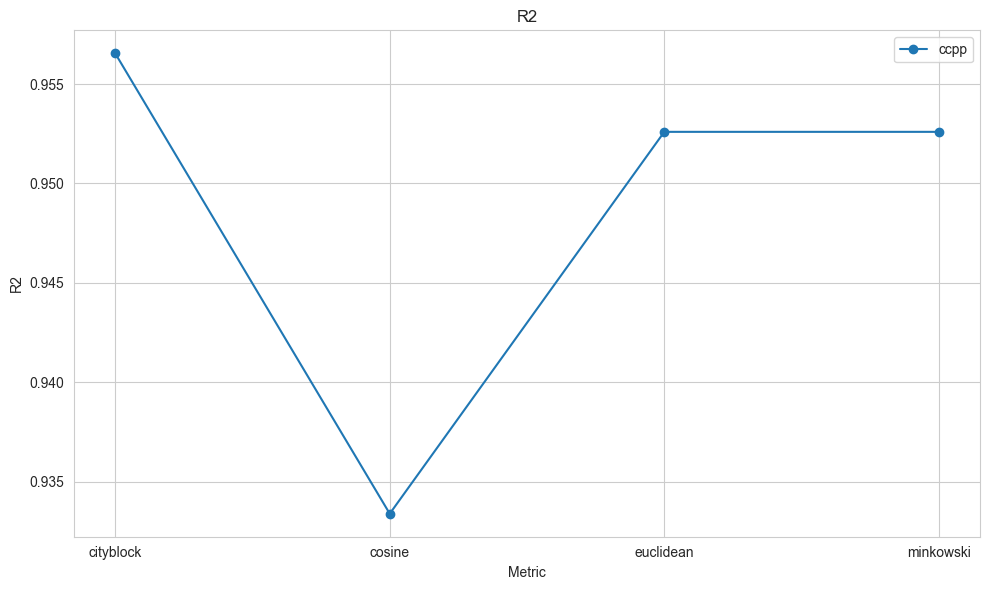

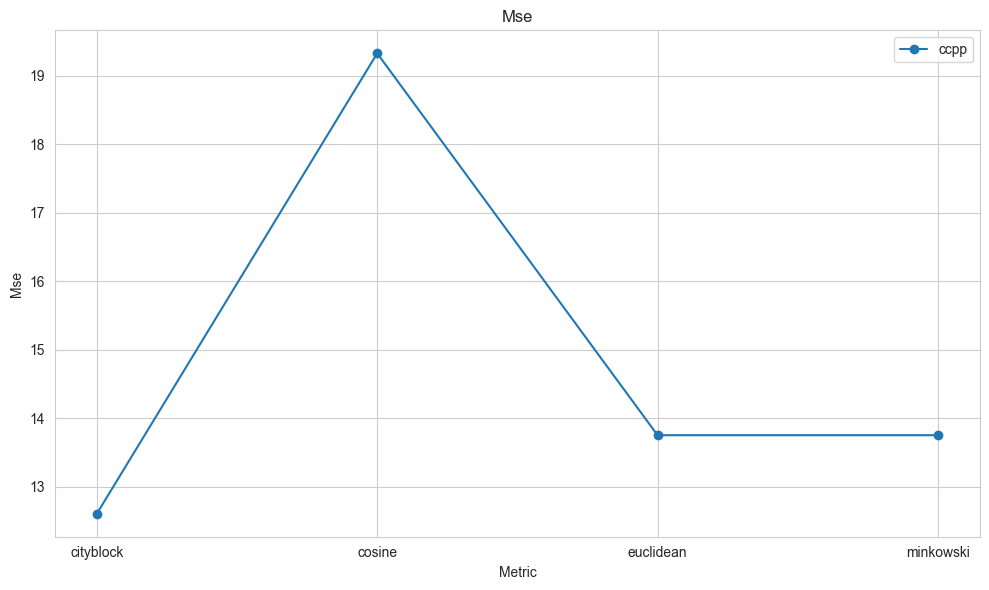

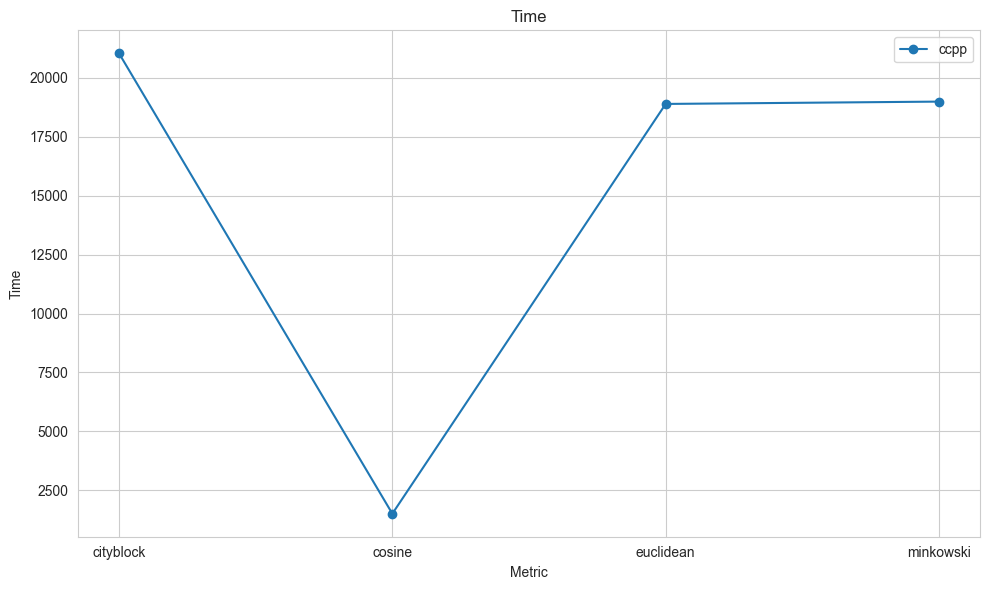

In [35]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    #'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'metric': ['euclidean', 'minkowski', 'cosine', 'cityblock']}
knn_metric_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                      hyperparameters=hyperparameters,
                                      hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_metric_ccpp}, x_axis='metric', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30}
Hyperparameter  metric  value:  euclidean
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  metric  value:  minkowski
R2:  0.5059790010704448
MSE:  0.10234812834224584
Hyperparameter  metric  value:  cosine
R2:  0.2505989174087654
MSE:  0.15525614973262022
Hyperparameter  metric  value:  cityblock
R2:  0.5471648408378315
MSE:  0.09381550802139031


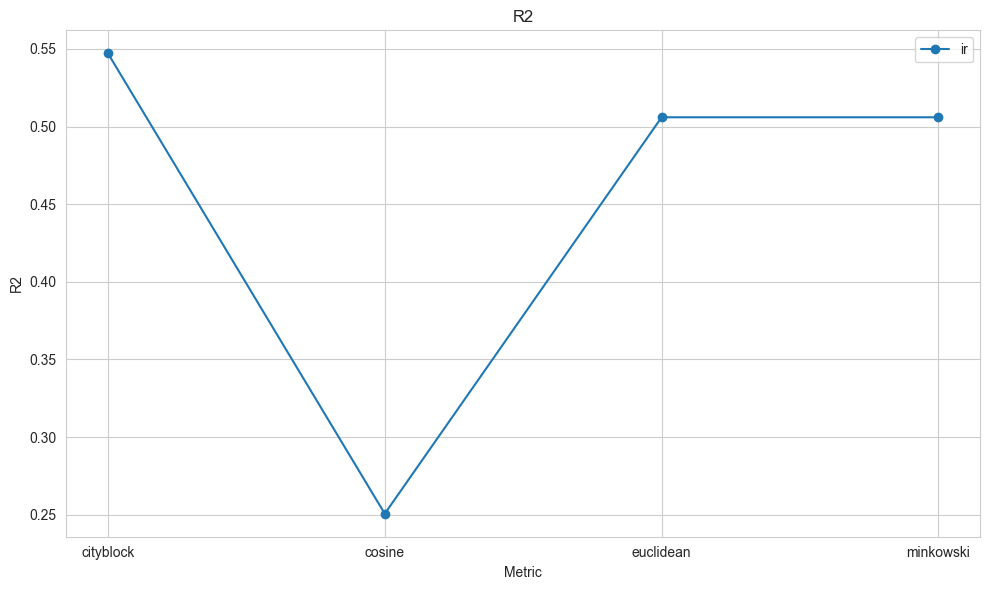

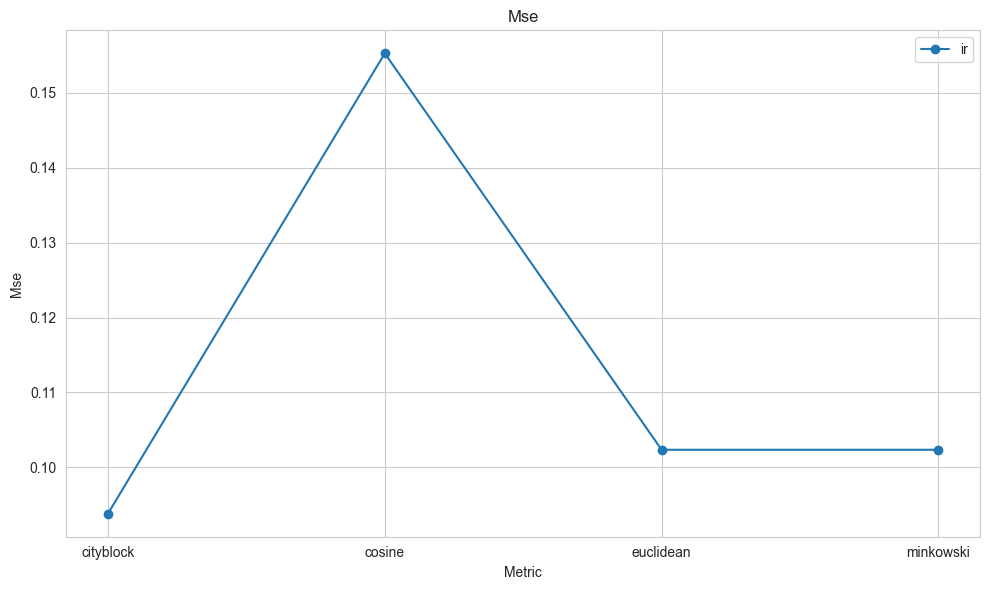

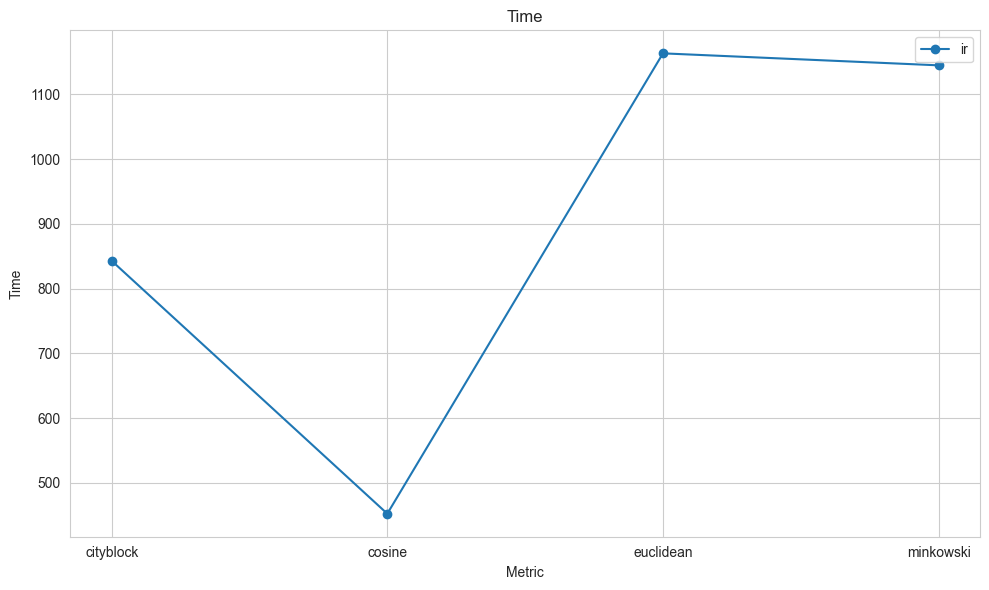

In [36]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    #'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'metric': ['euclidean', 'minkowski', 'cosine', 'cityblock']}
knn_metric_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                    hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_metric_ir}, x_axis='metric', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

In [37]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    #'metric': 'minkowski',
    'leaf_size': 30
}
hyperparameters_iterator = {'metric': ['euclidean', 'minkowski', 'cosine', 'cityblock']}
knn_metric_bf = evaluator.evaluate2(CustomKNeighborsRegressor, bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                    hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"bf": knn_metric_bf}, x_axis='metric', y_axis=['R2', 'MSE', 'time'], logaritmic=False)

Evaluating Model:  CustomKNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30}


KeyboardInterrupt: 

### leaf size

In [ ]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'minkowski',
    #'leaf_size': 30
}
hyperparameters_iterator = {'leaf_size': [1, 10, 100, 200, 500, 1000, 5000, 10000]}
knn_leaf_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                  hyperparameters=hyperparameters,
                                  hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_leaf_ir}, x_axis='leaf_size', y_axis=['time'], logaritmic=False)

In [ ]:
hyperparameters = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'minkowski',
    #'leaf_size': 30
}
hyperparameters_iterator = {'leaf_size': [1, 10, 100, 200, 500, 1000, 5000, 6000, 7000]}
knn_leaf_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                    hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_leaf_ccpp}, x_axis='leaf_size', y_axis=['time'], logaritmic=False)

In [ ]:
### algorithm

In [ ]:
hyperparameters = {
    'n_neighbors': 5,
    #'algorithm': 'kd_tree',
    'metric': 'minkowski',
    'leaf_size': 10
}
hyperparameters_iterator = {'algorithm': ['brute', 'kd_tree']}
knn_metric_ccpp = evaluator.evaluate2(CustomKNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                      hyperparameters=hyperparameters,
                                      hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ccpp": knn_metric_ccpp}, x_axis='algorithm', y_axis=['time'], logaritmic=False)

In [ ]:
hyperparameters = {
    'n_neighbors': 5,
    #'algorithm': 'kd_tree',
    'metric': 'minkowski',
    'leaf_size': 10
}
hyperparameters_iterator = {'algorithm': ['brute', 'kd_tree']}
knn_metric_ir = evaluator.evaluate2(CustomKNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                    hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"ir": knn_metric_ir}, x_axis='algorithm', y_axis=['time'], logaritmic=False)

In [ ]:
### sklearn vs custom

In [18]:
from sklearn.neighbors import KNeighborsRegressor
import time

# measure time of custom knn kd_tree
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_custom_time_kd = end - start

# measure time of custom knn brute
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_custom_time_brute = end - start

# measure time of sklearn knn kd_tree
knn = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_sklearn_time_kd = end - start

# measure time of sklearn knn brute
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ccpp_X_train, ccpp_y_train)
knn.predict(ccpp_X_test)
end = time.time()
ccpp_sklearn_time_brute = end - start

# same for ir
# measure time of custom knn kd_tree
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_custom_time_kd = end - start

# measure time of custom knn brute
knn = CustomKNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_custom_time_brute = end - start

# measure time of sklearn knn kd_tree
knn = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', metric='minkowski', leaf_size=30)
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_sklearn_time_kd = end - start

# measure time of sklearn knn brute
knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='minkowski')
start = time.time()
knn.fit(ir_X_train, ir_y_train)
knn.predict(ir_X_test)
end = time.time()
ir_sklearn_time_brute = end - start

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


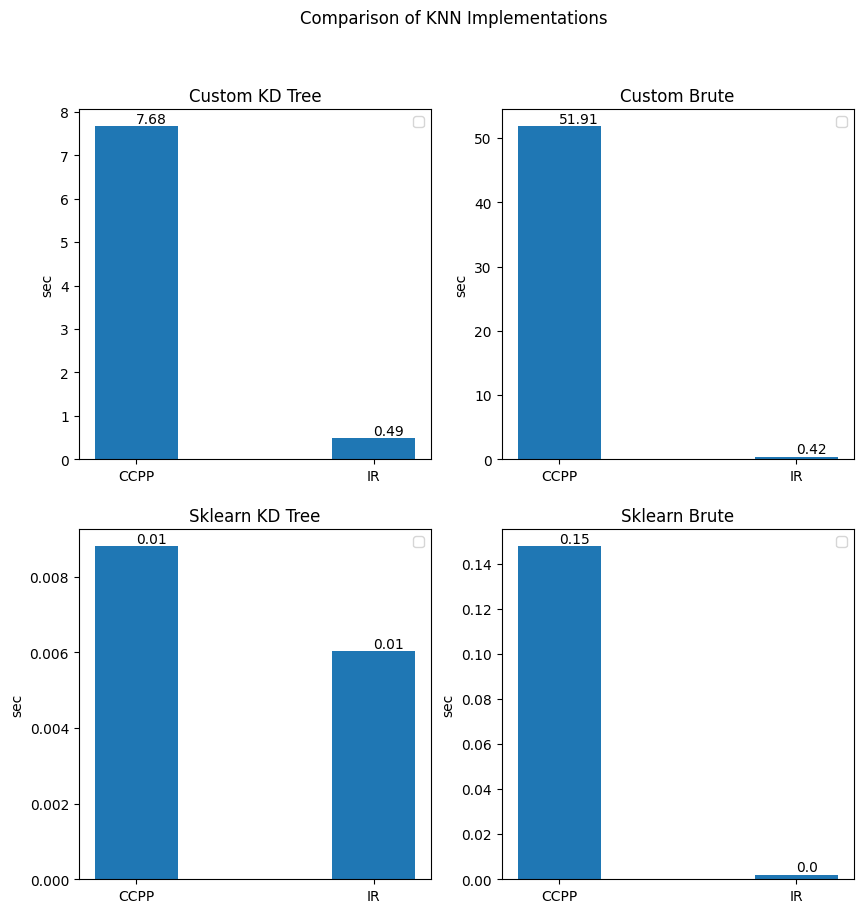

In [19]:

# draw a bar diagram
# group (ccpp_custom_time_kd, ir_custom_time_kd), (ccpp_custom_time_brute, ir_custom_time_brute), (ccpp_sklearn_time_kd, ir_sklearn_time_kd), (ccpp_sklearn_time_brute, ir_sklearn_time_brute)

import matplotlib.pyplot as plt
import numpy as np

# Define the data
group1 = [ccpp_custom_time_kd, ir_custom_time_kd]
group2 = [ccpp_custom_time_brute, ir_custom_time_brute]
group3 = [ccpp_sklearn_time_kd, ir_sklearn_time_kd]
group4 = [ccpp_sklearn_time_brute, ir_sklearn_time_brute]

# Create figure and 4 subplots with a larger size
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Define bar width and positions
bar_width = 0.35
x = np.arange(len(group1))

# Create bars for each subplot and add the values on top of the bars
for i, group in enumerate([group1, group2, group3, group4]):
    ax = axs[i // 2, i % 2]
    bars = ax.bar(x, group, width=bar_width)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# Set x-ticks to be the middle of the groups of bars
for ax in axs.flat:
    ax.set_xticks(x)
    ax.set_xticklabels(['CCPP', 'IR'])
    ax.legend()

# Add labels and title for each subplot
axs[0, 0].set_title('Custom KD Tree')
axs[0, 1].set_title('Custom Brute')
axs[1, 0].set_title('Sklearn KD Tree')
axs[1, 1].set_title('Sklearn Brute')

axs[0, 0].set_ylabel('sec')
axs[0, 1].set_ylabel('sec')
axs[1, 0].set_ylabel('sec')
axs[1, 1].set_ylabel('sec')

# Add a global title
fig.suptitle('Comparison of KNN Implementations')

# Show the plot
plt.show()



## gradient

# datasets

In [ ]:
## Decision Tree Regressor

In [ ]:
## Gradient Descent

In [ ]:
## KNN

In [27]:
## Infrared Thermo Temperature
tree_hyper = {
    'max_depth': 3,
}
knn_hyper = {
    'n_neighbors': 5,
    'algorithm': 'brute',
    'metric': 'cityblock',
    'leaf_size': 1000
}
gd_hyper = {
    "max_iter": 1000,
    "eta0": 0.001,
    "loss": "squared_error",
    "learning_rate": "constant",
    "tol": None,
    "shuffle": False,
    "penalty": None
}

gr_result = evaluator.evaluate2(SGDRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test, hyperparameters=gd_hyper,
                                hyperparameters_iterate={})
knn_result = evaluator.evaluate2(KNeighborsRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                 hyperparameters=knn_hyper,
                                 hyperparameters_iterate={})
tree_result = evaluator.evaluate2(DecisionTreeRegressor, ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                  hyperparameters=tree_hyper,
                                  hyperparameters_iterate={})

Evaluating Model:  SGDRegressor
Hyperparameters:  {'max_iter': 1000, 'eta0': 0.001, 'loss': 'squared_error', 'learning_rate': 'constant', 'tol': None, 'shuffle': False, 'penalty': None}
R2:  0.6524824591703281
MSE:  0.07199647372699777
Evaluating Model:  KNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'brute', 'metric': 'cityblock', 'leaf_size': 1000}
R2:  0.5471648408378315
MSE:  0.09381550802139031
Evaluating Model:  DecisionTreeRegressor
Hyperparameters:  {'max_depth': 3}
R2:  0.6917456382003224
MSE:  0.06386217802864944


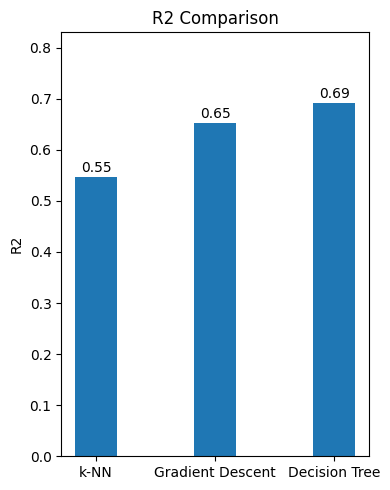

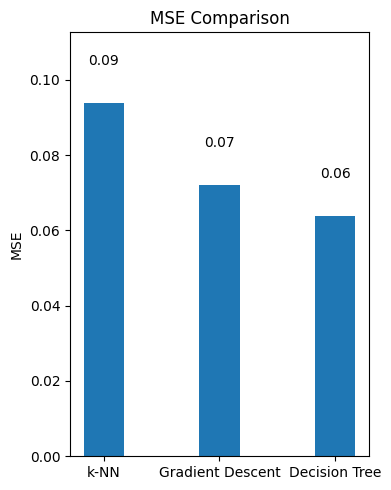

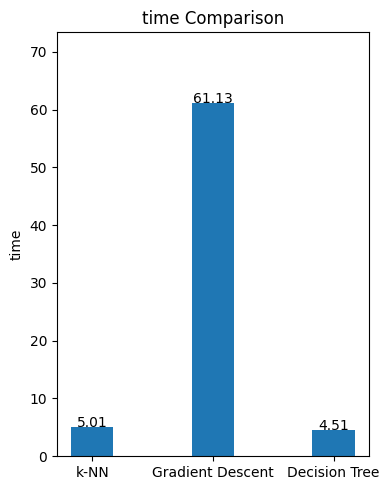

In [28]:
import matplotlib.pyplot as plt

# Extracting values from the dictionaries
metrics = ['R2', 'MSE', 'time']
labels = ['k-NN', 'Gradient Descent', 'Decision Tree']
values = {
    'R2': [knn_result['default']['R2'], gr_result['default']['R2'], tree_result['default']['R2']],
    'MSE': [knn_result['default']['MSE'], gr_result['default']['MSE'], tree_result['default']['MSE']],
    'time': [knn_result['default']['time'], gr_result['default']['time'], tree_result['default']['time']]
}

# Plotting each metric in a separate plot
for metric in metrics:
    plt.figure(figsize=(4, 5))
    plt.bar(labels, values[metric], width=0.35)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim([0, max(values[metric]) * 1.2])
    for j, value in enumerate(values[metric]):
        plt.text(j, value + 0.01, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

In [29]:
## Black Friday
tree_hyper = {
    'max_depth': 3,
}
knn_hyper = {
    'n_neighbors': 5,
    'algorithm': 'brute',
    'metric': 'cityblock',
    'leaf_size': 30
}
gd_hyper = {
    "max_iter": 1000,
    "eta0": 0.001,
    "loss": "squared_error",
    "learning_rate": "constant",
    "tol": None,
    "shuffle": False,
    "penalty": None
}
gr_result = evaluator.evaluate2(SGDRegressor, bf_X_train, bf_y_train, bf_X_test, bf_y_test, hyperparameters=gd_hyper,
                                hyperparameters_iterate={})
knn_result = evaluator.evaluate2(KNeighborsRegressor, bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                 hyperparameters=knn_hyper,
                                 hyperparameters_iterate={})
tree_result = evaluator.evaluate2(DecisionTreeRegressor, bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                  hyperparameters=tree_hyper,
                                  hyperparameters_iterate={})

Evaluating Model:  SGDRegressor
Hyperparameters:  {'max_iter': 1000, 'eta0': 0.001, 'loss': 'squared_error', 'learning_rate': 'constant', 'tol': None, 'shuffle': False, 'penalty': None}
R2:  0.16118514352261604
MSE:  21830527.393670313
Evaluating Model:  KNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'brute', 'metric': 'cityblock', 'leaf_size': 30}
R2:  0.3498458759279287
MSE:  16920548.44530016
Evaluating Model:  DecisionTreeRegressor
Hyperparameters:  {'max_depth': 3}
R2:  0.39710098525984716
MSE:  15690713.33830937


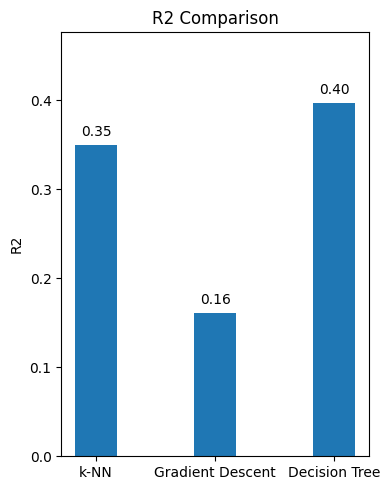

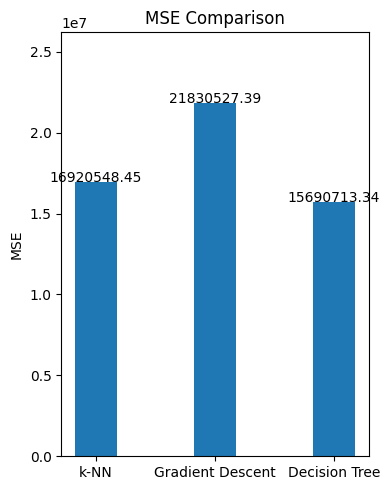

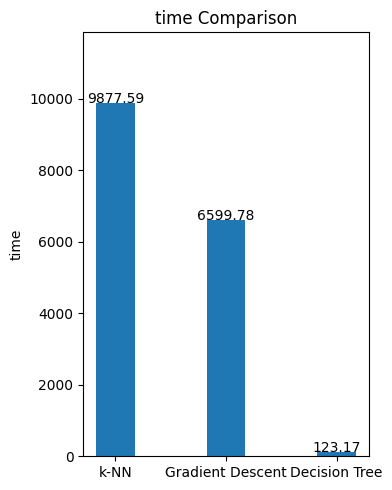

In [30]:
import matplotlib.pyplot as plt

# Extracting values from the dictionaries
metrics = ['R2', 'MSE', 'time']
labels = ['k-NN', 'Gradient Descent', 'Decision Tree']
values = {
    'R2': [knn_result['default']['R2'], gr_result['default']['R2'], tree_result['default']['R2']],
    'MSE': [knn_result['default']['MSE'], gr_result['default']['MSE'], tree_result['default']['MSE']],
    'time': [knn_result['default']['time'], gr_result['default']['time'], tree_result['default']['time']]
}

# Plotting each metric in a separate plot
for metric in metrics:
    plt.figure(figsize=(4, 5))
    plt.bar(labels, values[metric], width=0.35)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim([0, max(values[metric]) * 1.2])
    for j, value in enumerate(values[metric]):
        plt.text(j, value + 0.01, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

In [31]:
## Power Plant
tree_hyper = {
    'max_depth': 7,
}
knn_hyper = {
    'n_neighbors': 5,
    'algorithm': 'kd_tree',
    'metric': 'cityblock',
    'leaf_size': 500
}
gd_hyper = {
    "max_iter": 1000,
    "eta0": 0.001,
    "loss": "squared_error",
    "learning_rate": "constant",
    "tol": None,
    "shuffle": False,
    "penalty": None
}

gr_result = evaluator.evaluate2(SGDRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                hyperparameters=gd_hyper,
                                hyperparameters_iterate={})
knn_result = evaluator.evaluate2(KNeighborsRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                 hyperparameters=knn_hyper,
                                 hyperparameters_iterate={})
tree_result = evaluator.evaluate2(DecisionTreeRegressor, ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                  hyperparameters=tree_hyper,
                                  hyperparameters_iterate={})

Evaluating Model:  SGDRegressor
Hyperparameters:  {'max_iter': 1000, 'eta0': 0.001, 'loss': 'squared_error', 'learning_rate': 'constant', 'tol': None, 'shuffle': False, 'penalty': None}
R2:  0.9298314435969889
MSE:  20.35294972355264
Evaluating Model:  KNeighborsRegressor
Hyperparameters:  {'n_neighbors': 5, 'algorithm': 'kd_tree', 'metric': 'cityblock', 'leaf_size': 500}
R2:  0.9565464677922075
MSE:  12.60404377220482
Evaluating Model:  DecisionTreeRegressor
Hyperparameters:  {'max_depth': 7}
R2:  0.9427223748392791
MSE:  16.613832248237905


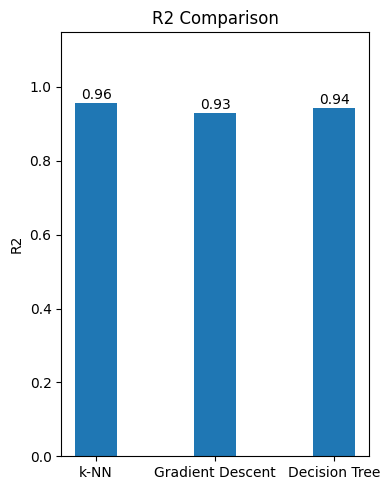

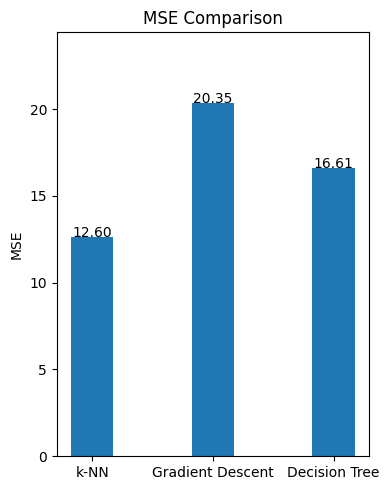

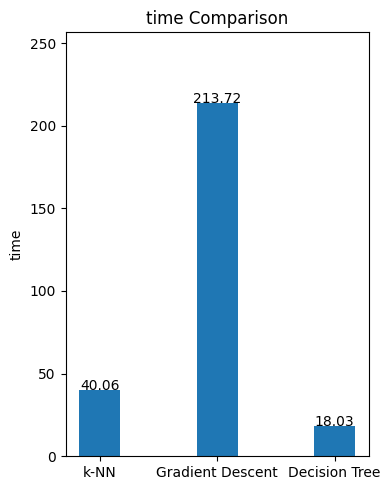

In [32]:
import matplotlib.pyplot as plt

# Extracting values from the dictionaries
metrics = ['R2', 'MSE', 'time']
labels = ['k-NN', 'Gradient Descent', 'Decision Tree']
values = {
    'R2': [knn_result['default']['R2'], gr_result['default']['R2'], tree_result['default']['R2']],
    'MSE': [knn_result['default']['MSE'], gr_result['default']['MSE'], tree_result['default']['MSE']],
    'time': [knn_result['default']['time'], gr_result['default']['time'], tree_result['default']['time']]
}

# Plotting each metric in a separate plot
for metric in metrics:
    plt.figure(figsize=(4, 5))
    plt.bar(labels, values[metric], width=0.35)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.ylim([0, max(values[metric]) * 1.2])
    for j, value in enumerate(values[metric]):
        plt.text(j, value + 0.01, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
## Gradient Descent Evaluation

In [ ]:
reload(evaluator)

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

max_iter = 10000

hyperparameters_my_gd = {
    'max_iter': max_iter,
}

hyperparameters_sgd = {
    'max_iter': max_iter,
    #'eta0': learning_rate,
    'loss': 'squared_error',
    'learning_rate': 'constant',
    'tol': None,
    'shuffle': False,
    'penalty': None,
}

bf_max_iter = 1000

bf_hyperparameters_my_gd = {
    'max_iter': bf_max_iter,
}

bf_hyperparameters_sgd = {
    'max_iter': bf_max_iter,
    #'eta0': learning_rate,
    'loss': 'squared_error',
    'learning_rate': 'constant',
    'tol': None,
    'shuffle': False,
    'penalty': None,
}

base_values = [0.05, 0.02, 0.01]
scaled_values = base_values.copy()
for i in range(1, 5):
    for value in base_values:
        scaled_values.append(value * (10 ** -i))
scaled_values.reverse()
scaled_values.pop()
scaled_values.pop()  # Remove 0.5 and 0.2 as it is not a sensible learning rate

my_sg_hyperparameters_iterator = {'learning_rate': scaled_values}
sgd_hyperparameters_iterator = {'eta0': scaled_values}

# MyGDRegressor

ir_learning_rate_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                       ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                       hyperparameters=hyperparameters_my_gd,
                                                       hyperparameters_iterate=my_sg_hyperparameters_iterator)

evaluator.draw_diagram2_list({"IR": ir_learning_rate_my_sg_regressor}, x_axis='learning_rate',
                             y_axis=['R2', 'MSE', 'time'], logaritmic=True)

ccpp_learning_rate_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                         ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                         hyperparameters=hyperparameters_my_gd,
                                                         hyperparameters_iterate=my_sg_hyperparameters_iterator)

evaluator.draw_diagram2_list({"CCPP": ccpp_learning_rate_my_sg_regressor}, x_axis='learning_rate',
                             y_axis=['R2', 'MSE', 'time'], logaritmic=True)

bf_learning_rate_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                       bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                                       hyperparameters=bf_hyperparameters_my_gd,
                                                       hyperparameters_iterate=my_sg_hyperparameters_iterator)

evaluator.draw_diagram2_list({"BF": bf_learning_rate_my_sg_regressor}, x_axis='learning_rate',
                             y_axis=['R2', 'MSE', 'time'], logaritmic=True)

# Sklearn SGDRegressor

ir_learning_rate_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                     ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                     hyperparameters=hyperparameters_sgd,
                                                     hyperparameters_iterate=sgd_hyperparameters_iterator)

evaluator.draw_diagram2_list({"IR": ir_learning_rate_sgd_regressor}, x_axis='eta0', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

ccpp_learning_rate_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                       ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                       hyperparameters=hyperparameters_sgd,
                                                       hyperparameters_iterate=sgd_hyperparameters_iterator)

evaluator.draw_diagram2_list({"CCPP": ccpp_learning_rate_sgd_regressor}, x_axis='eta0', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

bf_learning_rate_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                     bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                                     hyperparameters=bf_hyperparameters_sgd,
                                                     hyperparameters_iterate=sgd_hyperparameters_iterator)

evaluator.draw_diagram2_list({"BF": bf_learning_rate_sgd_regressor}, x_axis='eta0', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

In [ ]:
### Max Iterations

In [ ]:
import numpy as np

reload(evaluator)

ir_y_train = ir_y_train.astype(float)
ir_y_test = ir_y_test.astype(float)

learning_rate = 0.001

hyperparameters_my_gd = {
    #'max_iter': 1000,
    'learning_rate': learning_rate,
}

hyperparameters_sgd = {
    #'max_iter':1000, 
    'eta0': learning_rate,
    'loss': 'squared_error',
    'learning_rate': 'constant',
    'tol': None,
    'shuffle': False,
    'penalty': None,
}

base_values = [100, 200, 500]
scaled_values = base_values.copy()
for i in range(1, 3):
    for value in base_values:
        scaled_values.append(value * (10 ** i))
scaled_values.append(100000)
scaled_values.pop(0)  # Remove 100 as its not a useful max_iter value
scaled_values.pop(0)  # Remove 200 as its not a useful max_iter value

hyperparameters_iterator = {'max_iter': scaled_values}

# Remove large values as dataset bf is too large to run algorithms with such large max_iter
bf_scaled_values = [x for x in scaled_values if x not in [10000, 20000, 50000, 100000]]

bf_hyperparameters_iterator = {'max_iter': bf_scaled_values}

# MyGDRegressor

ir_max_iter_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                  ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                  hyperparameters=hyperparameters_my_gd,
                                                  hyperparameters_iterate=hyperparameters_iterator)

evaluator.draw_diagram2_list({"IR": ir_max_iter_my_sg_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

ccpp_max_iter_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                    ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                    hyperparameters=hyperparameters_my_gd,
                                                    hyperparameters_iterate=hyperparameters_iterator)

evaluator.draw_diagram2_list({"CCPP": ccpp_max_iter_my_sg_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

bf_max_iter_my_sg_regressor = evaluator.evaluate2(MyGDRegressor,
                                                  bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                                  hyperparameters=hyperparameters_my_gd,
                                                  hyperparameters_iterate=bf_hyperparameters_iterator)

evaluator.draw_diagram2_list({"BF": bf_max_iter_my_sg_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

# Sklearn SGDRegressor

ir_max_iter_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                ir_X_train, ir_y_train, ir_X_test, ir_y_test,
                                                hyperparameters=hyperparameters_sgd,
                                                hyperparameters_iterate=hyperparameters_iterator)

evaluator.draw_diagram2_list({"IR": ir_max_iter_sgd_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

ccpp_max_iter_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                  ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test,
                                                  hyperparameters=hyperparameters_sgd,
                                                  hyperparameters_iterate=hyperparameters_iterator)

evaluator.draw_diagram2_list({"CCPP": ccpp_max_iter_sgd_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)

bf_max_iter_sgd_regressor = evaluator.evaluate2(SGDRegressor,
                                                bf_X_train, bf_y_train, bf_X_test, bf_y_test,
                                                hyperparameters=hyperparameters_sgd,
                                                hyperparameters_iterate=bf_hyperparameters_iterator)

evaluator.draw_diagram2_list({"BF": bf_max_iter_sgd_regressor}, x_axis='max_iter', y_axis=['R2', 'MSE', 'time'],
                             logaritmic=True)